# Procedimiento de ensayo de puesta en marcha de Rover

Este cuaderno interactivo tiene como objetivo verificar la funcionalidad del Rover. Esta organizado en secciónes, donde cada sección es un un test que ejercita alguna de las funciones Rover.

**Contenido**

1. Precondiciones. Configuración de ambiente de prueba.
2. Test de conectividad.
3. Test de control de motores (manual). 
4. Test de lectura de tacómetros.
5. Test de lectura de IMU.
6. Test de lectura de GPS.
7. Test de lazo de control PID.
8. Cierre.

## 1. Precondiciones

## 2. Test de conectividad

In [ ]:
#!pip install pyserial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

In [81]:
ROVER_PORT = '/dev/ttyACM1'
ROVER_BAUDRATE = 9600

In [129]:
from rover import RoverClient
rover = RoverClient(ROVER_PORT,ROVER_BAUDRATE)

### Estado inicial de telemetrías

In [130]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 0
REJECTED_PACKETS: 0
LAST_OPCODE: 0x00
LAST_ERROR: 0x00
STATUS: 0x00


In [131]:
assert(rover.TMY_PARAM_ACCEPTED_PACKETS == 0)
assert(rover.TMY_PARAM_REJECTED_PACKETS == 0)
assert(rover.TMY_PARAM_LAST_OPCODE == 0)
assert(rover.TMY_PARAM_LAST_ERROR == 0)
assert(rover.TMY_PARAM_STATUS == 0)

Frecuencia de reportes.

In [194]:
rover.get_report_counts()

{'GENERAL_TELEMETRY': 7799,
 'COMMAND_EXECUTION_STATUS': 0,
 'IMU_AHRS_STATE': 0,
 'MOTION_CONTROL_STATE': 25724,
 'GPS_STATE': 2575,
 'INVALID': 1}

## Control básico y recepción de telemetrías de estado

In [371]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 0
REJECTED_PACKETS: 0
LAST_OPCODE: 0x00
LAST_ERROR: 0x00
STATUS: 0x00


In [195]:
accepted_packets_before = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_before = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_before = rover.TMY_PARAM_LAST_OPCODE
last_error_before = rover.TMY_PARAM_LAST_ERROR

rover.led_on()
time.sleep(1)

accepted_packets_after = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_after = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_after = rover.TMY_PARAM_LAST_OPCODE
last_error_after = rover.TMY_PARAM_LAST_ERROR

assert(accepted_packets_after == (accepted_packets_before+1))
assert(rejected_packets_after == rejected_packets_before)
assert(last_opcode_after == rover.CMD_LED_ON)

In [198]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 0
REJECTED_PACKETS: 0
LAST_OPCODE: 0x00
LAST_ERROR: 0x00
STATUS: 0x00


In [199]:
accepted_packets_before = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_before = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_before = rover.TMY_PARAM_LAST_OPCODE
last_error_before = rover.TMY_PARAM_LAST_ERROR

rover.led_off()
time.sleep(1)

accepted_packets_after = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_after = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_after = rover.TMY_PARAM_LAST_OPCODE
last_error_after = rover.TMY_PARAM_LAST_ERROR

assert(accepted_packets_after == (accepted_packets_before+1))
assert(rejected_packets_after == rejected_packets_before)
assert(last_opcode_after == rover.CMD_LED_OFF)

In [200]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 1
REJECTED_PACKETS: 0
LAST_OPCODE: 0x02
LAST_ERROR: 0x00
STATUS: 0x00


## 4. Test de control de motores (manual)

Estado inicial de motores.

In [260]:
rover.print_motor_tmy()

TACHO1_SPEED: 70.100
TACHO2_SPEED: 140.199
TACHO3_SPEED: 210.301
TACHO4_SPEED: 280.398
TACHO1_COUNT: 0.000
TACHO2_COUNT: 0.000
TACHO3_COUNT: 0.000
TACHO4_COUNT: 0.000
MOTOR_A_THROTTLE: 0
MOTOR_B_THROTTLE: 0
MOTOR_A_SETPOINT_SPEED: 0.000
MOTOR_B_SETPOINT_SPEED: 0.000


In [14]:
assert(rover.TMY_PARAM_MOTOR_A_THROTTLE == 0)
assert(rover.TMY_PARAM_MOTOR_B_THROTTLE == 0)

In [29]:
def plot_motor_command_vs_tmy(tmy_readings,title):
    fig,axes = plt.subplots(1,2,figsize=(18,6))

    axes[0].scatter(tmy_readings[:,0],tmy_readings[:,1],color="r")
    axes[0].set_title("MOTOR_A")
    axes[0].grid(which="Both")
    axes[0].set_xlabel("Valor escrito")
    axes[0].set_ylabel("Valor leído (TMY)")
    #axes[0].set_xlim(0,MAX_THROTTLE)
    #axes[0].set_ylim(0,MAX_THROTTLE)

    axes[1].scatter(tmy_readings[:,0],tmy_readings[:,2],color="b")
    axes[1].set_title("MOTOR_B")
    axes[1].grid(which="Both")
    axes[1].set_xlabel("Valor escrito")
    axes[1].set_ylabel("Valor leído (TMY)")
    #axes[1].set_xlim(0,MAX_THROTTLE)
    #axes[1].set_ylim(0,MAX_THROTTLE)

    fig.suptitle(title);

In [15]:
MAX_THROTTLE = 1024

In [27]:
rover.set_motor_throttles( 
    [0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

Moverse hacia adelante incrementando la velocidad gradualmente.

In [28]:
tmy_readings = []
for i in range(0,MAX_THROTTLE):
    tmy_readings.append( np.array([ i, rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE]) )    
    time.sleep(0.1)    
    rover.set_motor_throttles( [i, i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

tmy_readings = np.array(tmy_readings)  
plot_motor_command_vs_tmy(tmy_readings,title="Rampa hacia adelante")

NameError: name 'plot_motor_command_vs_tmy' is not defined

Decrementar la velocidad gradualmente.

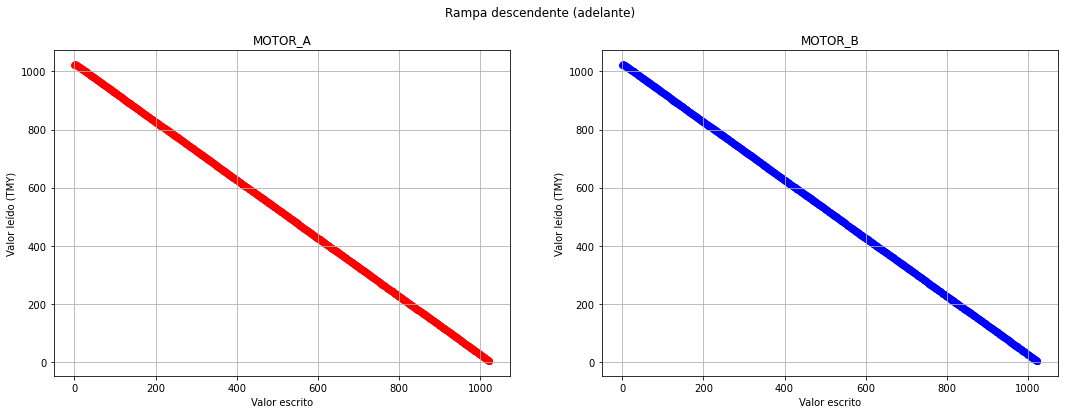

In [30]:
tmy_readings = []
for i in range(0,MAX_THROTTLE):
    tmy_readings.append( np.array([ i, rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE]) )    
    time.sleep(0.1)    
    rover.set_motor_throttles( [MAX_THROTTLE-i, MAX_THROTTLE-i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
    
tmy_readings = np.array(tmy_readings)  
plot_motor_command_vs_tmy(tmy_readings,title="Rampa descendente (adelante)")

Moverse hacia atrás incrementando la velocidad gradualmente.

Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 F3 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 F3 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0A 
Header inválido. Recibido: b'\xff\x00\x00\x00\x00\x00\x00\x00\x00u\xc6\n'


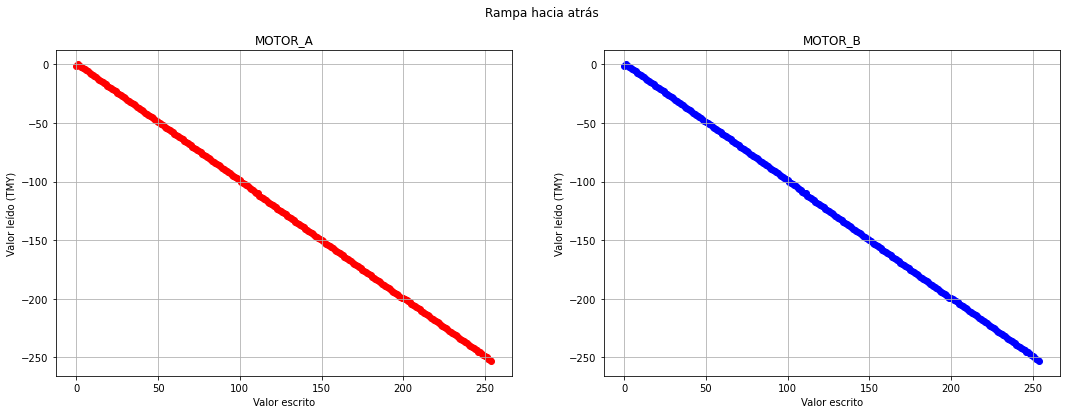

In [418]:
tmy_readings = []
for i in range(0,MAX_THROTTLE):
    rover.set_motor_throttles( [-i, -i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
    time.sleep(0.1)    
    tmy_readings.append( np.array([ i, rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE]) )

tmy_readings = np.array(tmy_readings)  
plot_motor_command_vs_tmy(tmy_readings,title="Rampa hacia atrás")

Decrementar la velocidad gradualmente.

Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 02 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 02 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0A 
Header inválido. Recibido: b'\xff\x00\x00\x00\x00\x00\x00\x00\x00\xed\xa5\n'
Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 2A 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 31 FF 31 FF 00 00 00 00 00 00 00 00 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 2A 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 31 FF 31 FF 00 00 00 00 00 00 00 00 0A 
Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 79 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 7E FF 7E FF 00 00 00 00 00 00 00 00 9F 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 79 00 03 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 7E FF 7E FF 00 00 00 00 00 00 00 00 9F 0A 


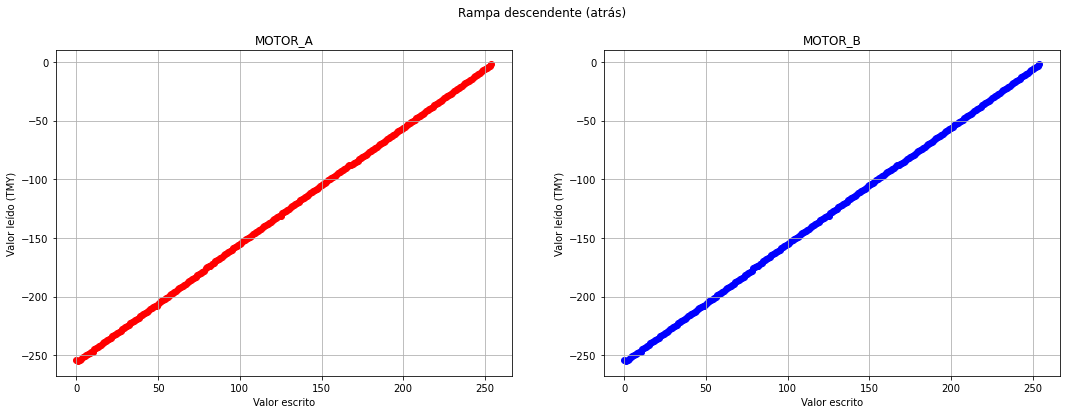

In [419]:
tmy_readings = []
for i in range(0,MAX_THROTTLE):
    rover.set_motor_throttles( [-MAX_THROTTLE+i, -MAX_THROTTLE+i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
    time.sleep(0.1)    
    tmy_readings.append( np.array([ i, rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE]) )

tmy_readings = np.array(tmy_readings)  
plot_motor_command_vs_tmy(tmy_readings,title="Rampa descendente (atrás)")   

## 5. Test de lectura de tacómetros

In [185]:
rover.print_motor_tmy()

TACHO1_SPEED: 0.000
TACHO2_SPEED: 0.000
TACHO3_SPEED: 0.000
TACHO4_SPEED: 0.000
TACHO1_COUNT: 0.000
TACHO2_COUNT: 0.000
TACHO3_COUNT: 0.000
TACHO4_COUNT: 0.000
MOTOR_A_THROTTLE: 0
MOTOR_B_THROTTLE: 0
MOTOR_A_SETPOINT_SPEED: 0.000
MOTOR_B_SETPOINT_SPEED: 0.000


In [524]:
t0 = datetime.datetime.now()
sampling_interval = 0.1
tmy_readings = []

# Rampa ascendente (hacia adelante)
for i in range(0,MAX_THROTTLE):
    t1 = datetime.datetime.now()
    tmy_readings.append( np.array([ t1, 
        rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE,
        rover.TMY_PARAM_TACHO1_SPEED,rover.TMY_PARAM_TACHO2_SPEED,
        rover.TMY_PARAM_TACHO3_SPEED,rover.TMY_PARAM_TACHO4_SPEED
    ]) ) 
    time.sleep(sampling_interval)
    rover.set_motor_throttles( [i, i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

# Rampa descendente (hacia adelante)
for i in range(0,MAX_THROTTLE):
    t1 = datetime.datetime.now()
    tmy_readings.append( np.array([ t1, 
        rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE,
        rover.TMY_PARAM_TACHO1_SPEED,rover.TMY_PARAM_TACHO2_SPEED,
        rover.TMY_PARAM_TACHO3_SPEED,rover.TMY_PARAM_TACHO4_SPEED
    ]) ) 
    time.sleep(sampling_interval)
    rover.set_motor_throttles( [MAX_THROTTLE-i, MAX_THROTTLE-i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )    
    
# Rampa ascendente (reversa)
for i in range(0,MAX_THROTTLE):
    t1 = datetime.datetime.now()
    tmy_readings.append( np.array([ t1, 
        rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE,
        rover.TMY_PARAM_TACHO1_SPEED,rover.TMY_PARAM_TACHO2_SPEED,
        rover.TMY_PARAM_TACHO3_SPEED,rover.TMY_PARAM_TACHO4_SPEED
    ]) ) 
    time.sleep(sampling_interval)    
    rover.set_motor_throttles( [-i, -i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
    
# Rampa descendete (reversahacia atrás)    
for i in range(0,MAX_THROTTLE):
    t1 = datetime.datetime.now()
    tmy_readings.append( np.array([ t1, 
        rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE,
        rover.TMY_PARAM_TACHO1_SPEED,rover.TMY_PARAM_TACHO2_SPEED,
        rover.TMY_PARAM_TACHO3_SPEED,rover.TMY_PARAM_TACHO4_SPEED
    ]) ) 
    time.sleep(sampling_interval)       
    rover.set_motor_throttles( [-MAX_THROTTLE+i, -MAX_THROTTLE+i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

tmy_readings = np.array(tmy_readings)  

Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 01 00 03 43 4B CA 44 43 4B CA 44 43 4B CA 44 43 4B CA 44 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 01 00 03 43 4B CA 44 43 4B CA 44 43 4B CA 44 43 4B CA 44 0A 
Header inválido. Recibido: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00q\xfa\n'
Tamaño de paquete inválido:  6 . Esperado:  14
Recibido: 50 4B 54 21 06 80 04 00 03 00 00 0A 
Reporte desconocido: Recibido: 50 4B 54 21 06 80 04 00 03 00 00 0A 
Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 1F 00 03 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 1F 00 03 0A 
Header inválido. Recibido: b"\xa8\xcaD'\x00'\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa3\xf3\n"
Tamaño de paquete inválido:  32 . Esperado:  40
Recibido: 50 4B 54 21 20 83 3F 00 03 9D 11 CB 44 9D 11 CB 44 9D 11 CB 44 9D 11 CB 44 48 00 48 00 00 00 00 00 00 00 00 00 0A 
Reporte desconocido: Recibido: 50 4B 54 21 20 83 3F 00 03 9D 11 CB 44 9D 11 CB 44 9D 11 CB 44 9D 11 C

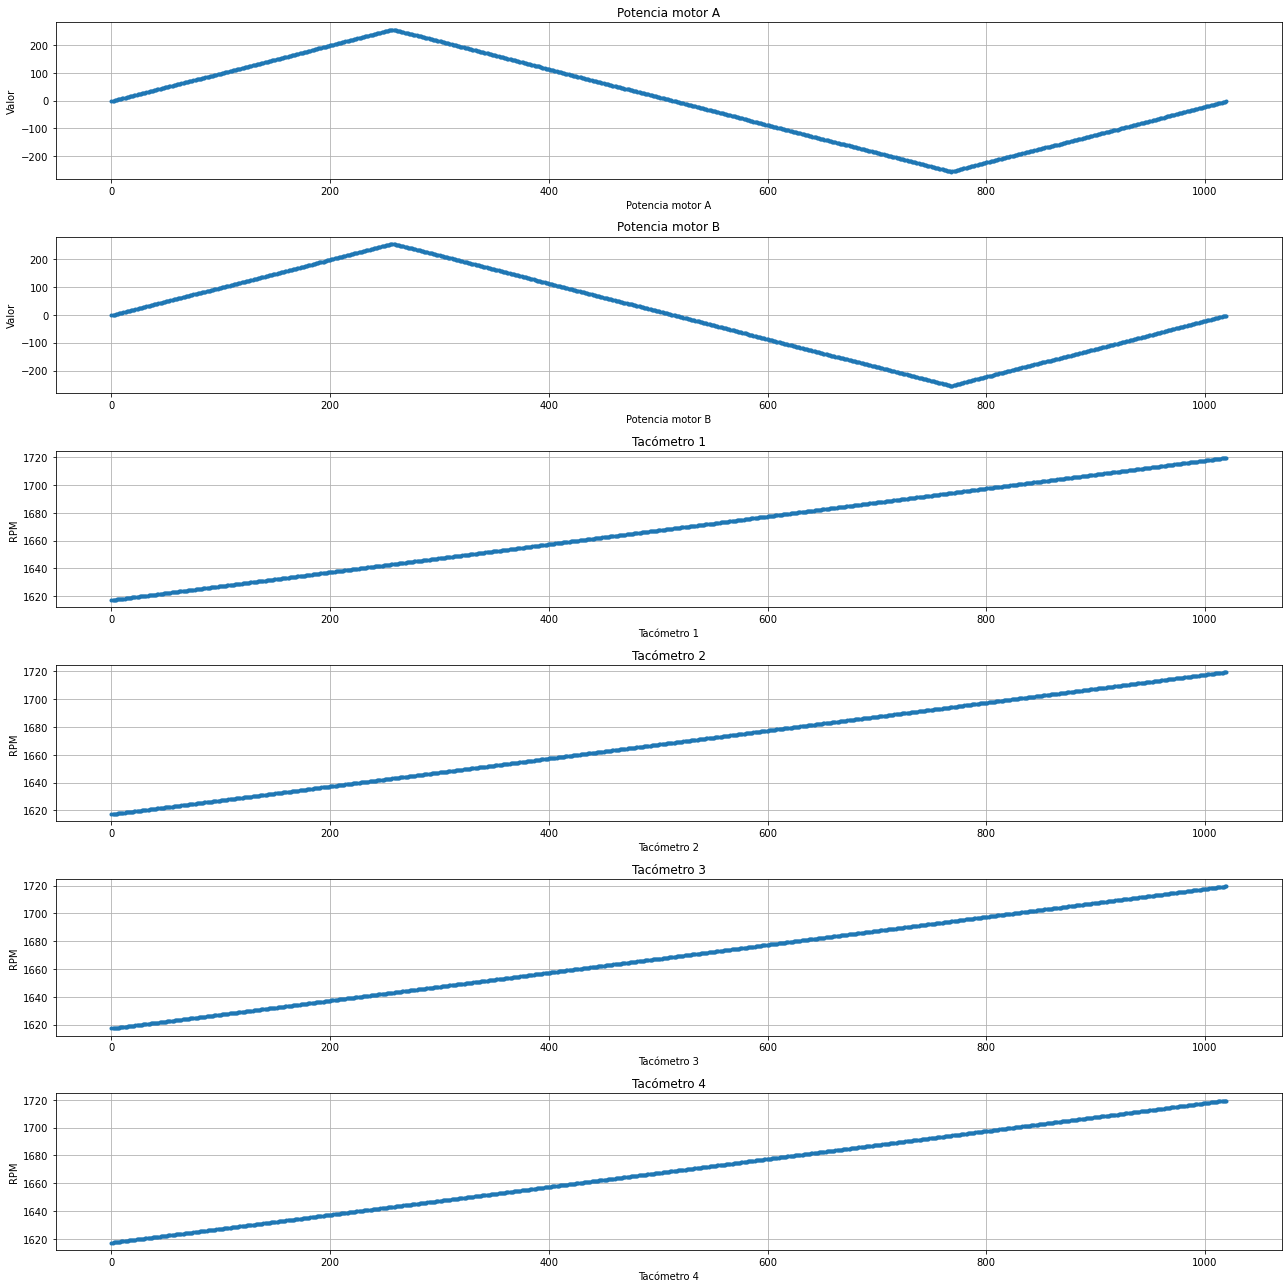

In [529]:
fig,axes = plt.subplots(6,1,figsize=(18,6*3))

samples_idx = np.arange(len(tmy_readings))

tmys = [
    ["Potencia motor A", "Valor"],
    ["Potencia motor B", "Valor"],
    ["Tacómetro 1", "RPM"],
    ["Tacómetro 2", "RPM"],
    ["Tacómetro 3", "RPM"],
    ["Tacómetro 4", "RPM"]
]

for i in range(6):
    axes[i].plot(samples_idx,tmy_readings[:,1+i],marker=".")
    axes[i].grid(which="Both")
    axes[i].set_xlabel(tmys[i][0])
    axes[i].set_ylabel(tmys[i][1])
    axes[i].set_title(tmys[i][0])
fig.tight_layout()

## 6. Test de lectura de IMU

In [ ]:
#FIXME

## 7. Test de lectura de GPS

In [ ]:
#FIXME

## 8. Test de lazo de control PID

In [ ]:
tmy_readings = []
for i in range(0,MAX_THROTTLE):
    tmy_readings.append( np.array([ i, rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE]) )    
    time.sleep(0.1)    
    rover.set_motor_throttles( [i, i], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

tmy_readings = np.array(tmy_readings)  
plot_motor_command_vs_tmy(tmy_readings,title="Rampa hacia adelante")

## Tear down

Desconectarse del rover para liberar el puerto serie.

In [75]:
rover.disconnect()

# Debugging

In [ ]:
import struct
payload = bytearray(rover.payload)
"".join(["%02x " % x for x in payload])
parsed = struct.unpack('<ccc4f2h2f', payload)
parsed[0]

In [ ]:
struct.pack('<2f',1024.4,921.2)[0]

In [ ]:
struct.pack('<2h',-125,231)[2]

~~~
00 00 00 

00 00 c8 42 
00 00 48 43 
00 00 96 43 
00 00 c8 43 
ff 01 00 ff 
00 00 80 44 
00 00 80 c4

~~~

In [ ]:
00 00 00 00 00 c8 42 00 00 48 43 00 00 96 43 00 00 c8 43 ff 01 00 ff 00 00 80 44 00 00 80 c4